# Denoising autoencoder

In [1]:
%matplotlib inline

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tf_utils import FullyConnectedLayer, FeedForwardNet
from vis_utils import tilePatches

# Data handler included in TF examples (downloads data)
mnist = input_data.read_data_sets('../data/mnist', one_hot=True)

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Extracting ../data/mnist/train-images-idx3-ubyte.gz
Extracting ../data/mnist/train-labels-idx1-ubyte.gz
Extracting ../data/mnist/t10k-images-idx3-ubyte.gz
Extracting ../data/mnist/t10k-labels-idx1-ubyte.gz


## Compute corrupted input reconstruction
We will use zero masking noise to corrupt the input patterns

In [2]:
n_hid = 128
encoder_net = FeedForwardNet()
encoder_net.addLayer(FullyConnectedLayer((784, n_hid), 'sigmoid'))

decoder_net = FeedForwardNet()
decoder_net.addLayer(FullyConnectedLayer((n_hid, 784), 'identity'))

x = tf.placeholder(tf.float32, [None, 784])
# Corrupt input with zero mask noise
x_crr = tf.placeholder(tf.float32, [None, 784])
x_enc = encoder_net.forward(x_crr)
y_dec = decoder_net.forward(x_enc)
x_dec = tf.nn.sigmoid(y_dec)

rec_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=y_dec))


In [3]:
train_step = tf.train.MomentumOptimizer(0.5, 0.9).minimize(rec_cost)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [4]:
zprob = 0.30
n_iter = 40000
for i in range(n_iter):
    batch_xs, _ = mnist.train.next_batch(100)
    ## corrupt batch
    batch_crr = batch_xs.copy()
    batch_crr[np.random.uniform(size=batch_crr.shape) < zprob] = 0.0
    ## display training accuracy 
    if i%(n_iter/10) == 0:
        train_cost = rec_cost.eval(feed_dict={
        x:batch_xs, x_crr:batch_crr })
        print("step %d, training cost %g"%(i, train_cost))
    ## 
    sess.run(train_step, feed_dict={x: batch_xs, x_crr:batch_crr})

step 0, training cost 0.758495
step 4000, training cost 0.153315
step 8000, training cost 0.132081
step 12000, training cost 0.126475
step 16000, training cost 0.119398
step 20000, training cost 0.107463
step 24000, training cost 0.111793
step 28000, training cost 0.10469
step 32000, training cost 0.103714
step 36000, training cost 0.102747


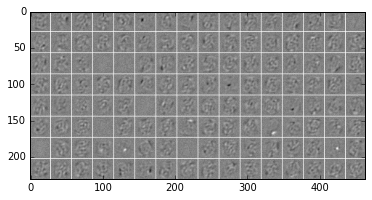

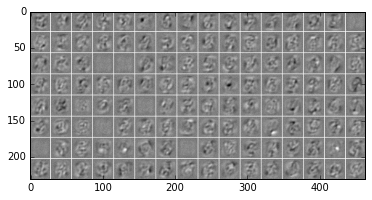

In [5]:
# visualize the encoder filters
W_enc = encoder_net.layers[0].params['W'].eval()
enc_filters = tilePatches(np.reshape(W_enc, [28, 28, -1]), ncol=16)
plt.imshow(enc_filters[:,:,0], cmap='gray')
plt.show()
# visualize the decoder filters
W_dec = decoder_net.layers[0].params['W'].eval()
dec_filters = tilePatches(np.reshape(W_dec.transpose(), [28, 28, -1]), ncol=16)
plt.imshow(dec_filters[:,:,0], cmap='gray')
plt.show()

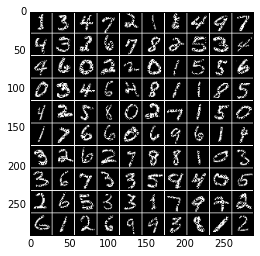

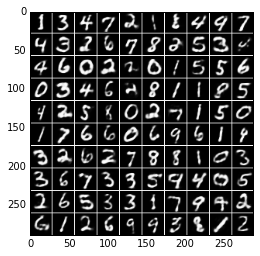

In [9]:
# visualize reconstructions
batch_rec = sess.run(x_dec, feed_dict={x_crr:batch_crr})
tiled_batch_crr = tilePatches(np.reshape(batch_crr.transpose(), [28, 28, -1]), ncol=10)
tiled_batch_rec = tilePatches(np.reshape(batch_rec.transpose(), [28, 28, -1]), ncol=10)
plt.imshow(tiled_batch_crr[:,:,0], cmap='gray')
plt.show()
plt.imshow(tiled_batch_rec[:,:,0], cmap='gray')
plt.show()